# NOTEBOOOK DE CREATION DES ORIGINE DESTINATION LAPI

In [2]:
%load_ext autoreload
%autoreload 2
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin\git\Outils\Outils\Martin_Perso')
import traitement_od as t
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
import os, math
from sklearn.cluster import DBSCAN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. import des données, traitement de mise en forme
### 1.1 Import

In [3]:
%%time 
#df_3semaines=pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\df_3semaines.json', orient='index')
df_3semaines=t.ouvrir_fichier_lapi('2019-01-28 00:00:00','2019-02-17 23:59:59')
df_3semaines=df_3semaines.set_index('created').sort_index()

Wall time: 2min 22s


## 1.2 Traitement des doublons

In [ ]:
#trouver les doublons
doublons=df_3semaines.reset_index()
doublons.loc[doublons.duplicated(['created','immat'],keep=False)]
#supprimer les doublons
#df_3semaines=df_3semaines.drop_duplicates(['created','immat'])

In [27]:
%%time 
#verifier si des passages sont trop proches

#fonction de test d'ecart entre les passages
def ecart_passage(liste_passage, liste_camera,state) : 
    for i in range(len(liste_passage)-1):
        if (pd.to_datetime(liste_passage[i+1])-pd.to_datetime(liste_passage[i])<pd.Timedelta('00:05:00') and 
            pd.to_datetime(liste_passage[i])!=pd.to_datetime(liste_passage[i+1]) and state!='!!') : #on trouve l'enchainement en moins de 5minutes, sans prendre les doublons
            return True
    else : return False
def conserver_state(liste_state):
    if '!!' in liste_state : 
        return '!!'
    else : return liste_state[0]
def test_unicite_type(liste_l, mode='unique'):
        if mode=='unique' : 
            if len(set(liste_l))==1 :
                return liste_l[0]
            else : 
                return -1
        elif mode=='1/2' :
            if any(liste_l)==1 : 
                return 1
            else : 
                return -1
def liste_passage(liste_cam, liste_created) : 
    liste_passage=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_passage.append(liste_cam[i])
            liste_passage.append(liste_cam[i+1])
    return liste_passage
def liste_created(liste_cam, liste_created) : 
    liste_created_fin=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_created_fin.append(liste_created[i])
            liste_created_fin.append(liste_created[i+1])
    return liste_created_fin

#on grouep les données et modifie les colonnes
groupe=(df_3semaines.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x),'l': lambda x : test_unicite_type(list(x),'1/2'), 
                                                              'created':lambda x: tuple(x),'state':lambda x : conserver_state(list(x)) }))
#on isole les pl
groupe_pl=groupe.loc[groupe['l']==1].copy()
#on ajoute une colonne drapeau pour localiser le pb
groupe_pl['erreur_tps_passage']=groupe_pl.apply(lambda x :  ecart_passage(x['created'], x['camera_id'], x['state']),axis=1)
#et on extrait unqiement les passages problemetaique
groupe_pl_rappro=groupe_pl[groupe_pl['erreur_tps_passage']].copy()
groupe_pl_rappro['liste_passag_faux']=groupe_pl_rappro.apply(lambda x : liste_passage(x['camera_id'],x['created']),axis=1)
groupe_pl_rappro['liste_created_faux']=groupe_pl_rappro.apply(lambda x : liste_created(x['camera_id'],x['created']),axis=1)
#obteniur le nobre de passages concernés
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']].apply(lambda x :len(x['liste_passag_faux']),axis=1).sum()
#visu
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']]

#!!!!!!! ATTENTION : PAS DE TRAITEMENTS EFFECTUES POUR CES ERREURS POUR LE MOMENT !
#propositions : supprimer 1 des 2 occurences pour les docblons
#supprmer les plques mal lues.


In [27]:
#redresser la valeur de l
df_journee.loc[df_journee['camera_id']==15,'l']=1

# 2. Création des trajets
## 2.1 Listes des trajets
>Listes créées à la main au départ, puis sauvegardée dans un fichier json.<br> Contient la liste des trajets "complet" i.e avec la camera de début et de fin, et la liste des trajets "incomplet" i.e où il peut manquer la camera de debut ou de fin (**attention, pour le moement le cas de A63 est traité à part pour le cas incomplet, car en fait les cas incomplet A63 renvoi un trajet de transit qui s'arrete à A660**).<br> on ajoute ensuite les données de longueur et tempsdeparcours théorique, sur la base d'un vitesse pl motyenne de 80 km/h pour vavoir un peu de marge

In [4]:
liste_complete_trajet=pd.read_json(r'E:\Boulot\lapi\trajets_possibles.json', orient='index')
liste_complete_trajet['cameras']=liste_complete_trajet.apply(lambda x : tuple(x['cameras']),axis=1)
liste_complete_trajet['tps_parcours_theoriq']=liste_complete_trajet.apply(lambda x : pd.Timedelta(milliseconds=x['tps_parcours_theoriq']),axis=1)
liste_complete_trajet.sort_values('nb_cams', ascending=False, inplace=True)

In [41]:
liste_complete_trajet

,cam_d,cam_o,cameras,destination,long_km,nb_cams,o_d,origine,tps_parcours_theoriq
0,11,15,"(15, 19, 4, 5, 11)",A10,120.325213,5,A63-A10,A63,01:30:14.634000
1,11,15,"(15, 19, 1, 5, 11)",A10,125.202188,5,A63-A10,A63,01:33:54.098000
13,13,12,"(12, 6, 3, 18, 13)",A63,105.139253,5,A10-A63,A10,01:18:51.266000
12,13,12,"(12, 6, 2, 18, 13)",A63,108.707013,5,A10-A63,A10,01:21:31.815000
56,7,15,"(15, 19, 4, 7)",A89,90.709158,4,A63-A89,A63,01:08:01.912000
36,11,10,"(10, 4, 5, 11)",A10,64.969553,4,A62-A10,A62,00:48:43.629000
31,13,6,"(6, 3, 18, 13)",A63,85.355597,4,N10-A63,N10,01:04:01.001000
25,5,15,"(15, 19, 1, 5)",N10,89.925738,4,A63-N10,A63,01:07:26.658000
24,5,15,"(15, 19, 4, 5)",N10,85.048763,4,A63-N10,A63,01:03:47.194000
30,13,6,"(6, 2, 18, 13)",A63,88.923357,4,N10-A63,N10,01:06:41.551000


In [5]:
"""liste_trajet_incomplet=pd.DataFrame(np.array([[4, 15, (15,19,4), 'N10',85.048763,3,'A63-N10','A63','01:03:47.194000'], 
                                              [1, 15, (15,19,1), 'N10',89.925738,3,'A63-N10','A63','01:07:26.658000'],
                                              [4, 15, (15,4), 'N10',85.048763,2,'A63-N10','A63','01:03:47.194000'],
                                              [1, 15, (15,1), 'N10',89.925738,2,'A63-N10','A63','01:07:26.658000'],
                                              [4, 15, (15,19,4), 'A89',90.709158,3,'A63-A89','A63','01:08:01.912000'],
                                              [4, 15, (15,4), 'A89',90.709158,2,'A63-A89','A63','01:08:01.912000'],
                                              [19, 15, (15,19), 'A62',73.187282,2,'A63-A62','A63','00:54:53.427000'],
                                              [4, 10, (10,4), 'N10',29.693103,2,'A62-N10','A62','00:22:16.189000'],
                                              [4, 10, (10,4), 'A89',35.353498,2,'A62-A89','A62','00:26:30.907000'],
                                              [3, 8, (8,3), 'A62',36.003136,2,'A89-A62','A89','00:27:00.141000']
                                             ]),
                                    columns=['cam_d', 'cam_o', 'cameras','destination', 'long_km', 'nb_cams','o_d', 'origine', 'tps_parcours_theoriq'])"""
liste_trajet_incomplet=pd.read_json(r'E:\Boulot\lapi\liste_trajet_incomplet.json', orient='index')
liste_trajet_incomplet['cameras']=liste_trajet_incomplet.apply(lambda x : tuple(x['cameras']),axis=1)
liste_trajet_incomplet['tps_parcours_theoriq']=liste_trajet_incomplet.apply(lambda x : pd.Timedelta(x['tps_parcours_theoriq']),axis=1)
liste_trajet_incomplet.sort_values('nb_cams', ascending=False, inplace=True)
liste_trajet_incomplet

,cam_d,cam_o,cameras,destination,long_km,nb_cams,o_d,origine,tps_parcours_theoriq
0,4,15,"(15, 19, 4)",N10,85.048763,3,A63-N10,A63,01:03:47.194000
1,1,15,"(15, 19, 1)",N10,89.925738,3,A63-N10,A63,01:07:26.658000
4,4,15,"(15, 19, 4)",A89,90.709158,3,A63-A89,A63,01:08:01.912000
2,4,15,"(15, 4)",N10,85.048763,2,A63-N10,A63,01:03:47.194000
3,1,15,"(15, 1)",N10,89.925738,2,A63-N10,A63,01:07:26.658000
5,4,15,"(15, 4)",A89,90.709158,2,A63-A89,A63,01:08:01.912000
6,19,15,"(15, 19)",A62,73.187282,2,A63-A62,A63,00:54:53.427000
7,4,10,"(10, 4)",N10,29.693103,2,A62-N10,A62,00:22:16.189000
8,4,10,"(10, 4)",A89,35.353498,2,A62-A89,A62,00:26:30.907000
9,3,8,"(8, 3)",A62,36.003136,2,A89-A62,A89,00:27:00.141000


## 2.2 Constitution de la base des trajets de transit
>obtention de 3 dataframes : 
- contenant les trajets de transit
- contenant les passages de transit
- contenant les temps maxi autorisés pour etre considéré comme transit, et le type detems maxi (cluster ou reglementaire)

### 2.2.1. Base : trajets qui collent avec ceux prévus dans la liste des trajets

In [6]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-28 00:00:00',8,df_3semaines)

date : 2019-01-28 00:00:00 debut_traitement : 2019-05-05 18:29:53.932295
date : 2019-01-29 00:00:00 debut_traitement : 2019-05-05 18:31:24.850636
date : 2019-01-30 00:00:00 debut_traitement : 2019-05-05 18:33:15.191147
date : 2019-01-31 00:00:00 debut_traitement : 2019-05-05 18:34:57.149433
date : 2019-02-01 00:00:00 debut_traitement : 2019-05-05 18:36:53.594129
date : 2019-02-02 00:00:00 debut_traitement : 2019-05-05 18:38:55.988312
date : 2019-02-03 00:00:00 debut_traitement : 2019-05-05 18:40:56.680451
date : 2019-02-04 00:00:00 debut_traitement : 2019-05-05 18:42:39.934958


*important : controle si doublons entre trajets*.<br> pourrait faire l'objet d'une fonction supp

In [ ]:
for destination in ['N10','A10','A63','A660', 'A89', 'A62'] : 
    print (t.verif_doublons_trajet(dico_od, destination))

### 2.2.2. Filtrer les trajets selon un temps de parcours
> Lorsque l'on utilise transit_temps_complet, le dico de stemps max est crée (On regroupe les trajets par Cluster, on utilise une df des parametres à utiliser pour les cluster basée sur des observations perso et un travail à la main). <br> En premier lieu on corrige ce dico des temps max en prenant un moyenne des temps max de type Cluster lorsque ceux ci encadre un temps max de type '85_percentile). <br> Là, on met un attribut drapeau pour identifier les trajets de transit.<br> la fonction graph_transit_filtre_multiple permet de visualiser les trajets de transit sur plusieurs jours, pour une o_d

In [7]:
#pour info : parametres cluster
param_cluster=pd.read_json(r'E:\Boulot\lapi\param_cluster.json', orient='index')
param_cluster

,delai,nb_pt_min,temps_etudie,trajet
0,600,4,15,"[A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
1,1200,4,60,"[A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
2,800,3,15,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"
3,1000,4,60,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"


In [8]:
#dico des temps max issus du lapi corrigé avec moyenne cluster
dixco_tpsmax_corrige=t.corriger_df_tps_parcours(dico_tps_max)

In [9]:
# df complete avec l'atribut filtre
df_transit_avec_filtre=t.jointure_temps_reel_theorique(dico_od,dixco_tpsmax_corrige,liste_complete_trajet, 15)

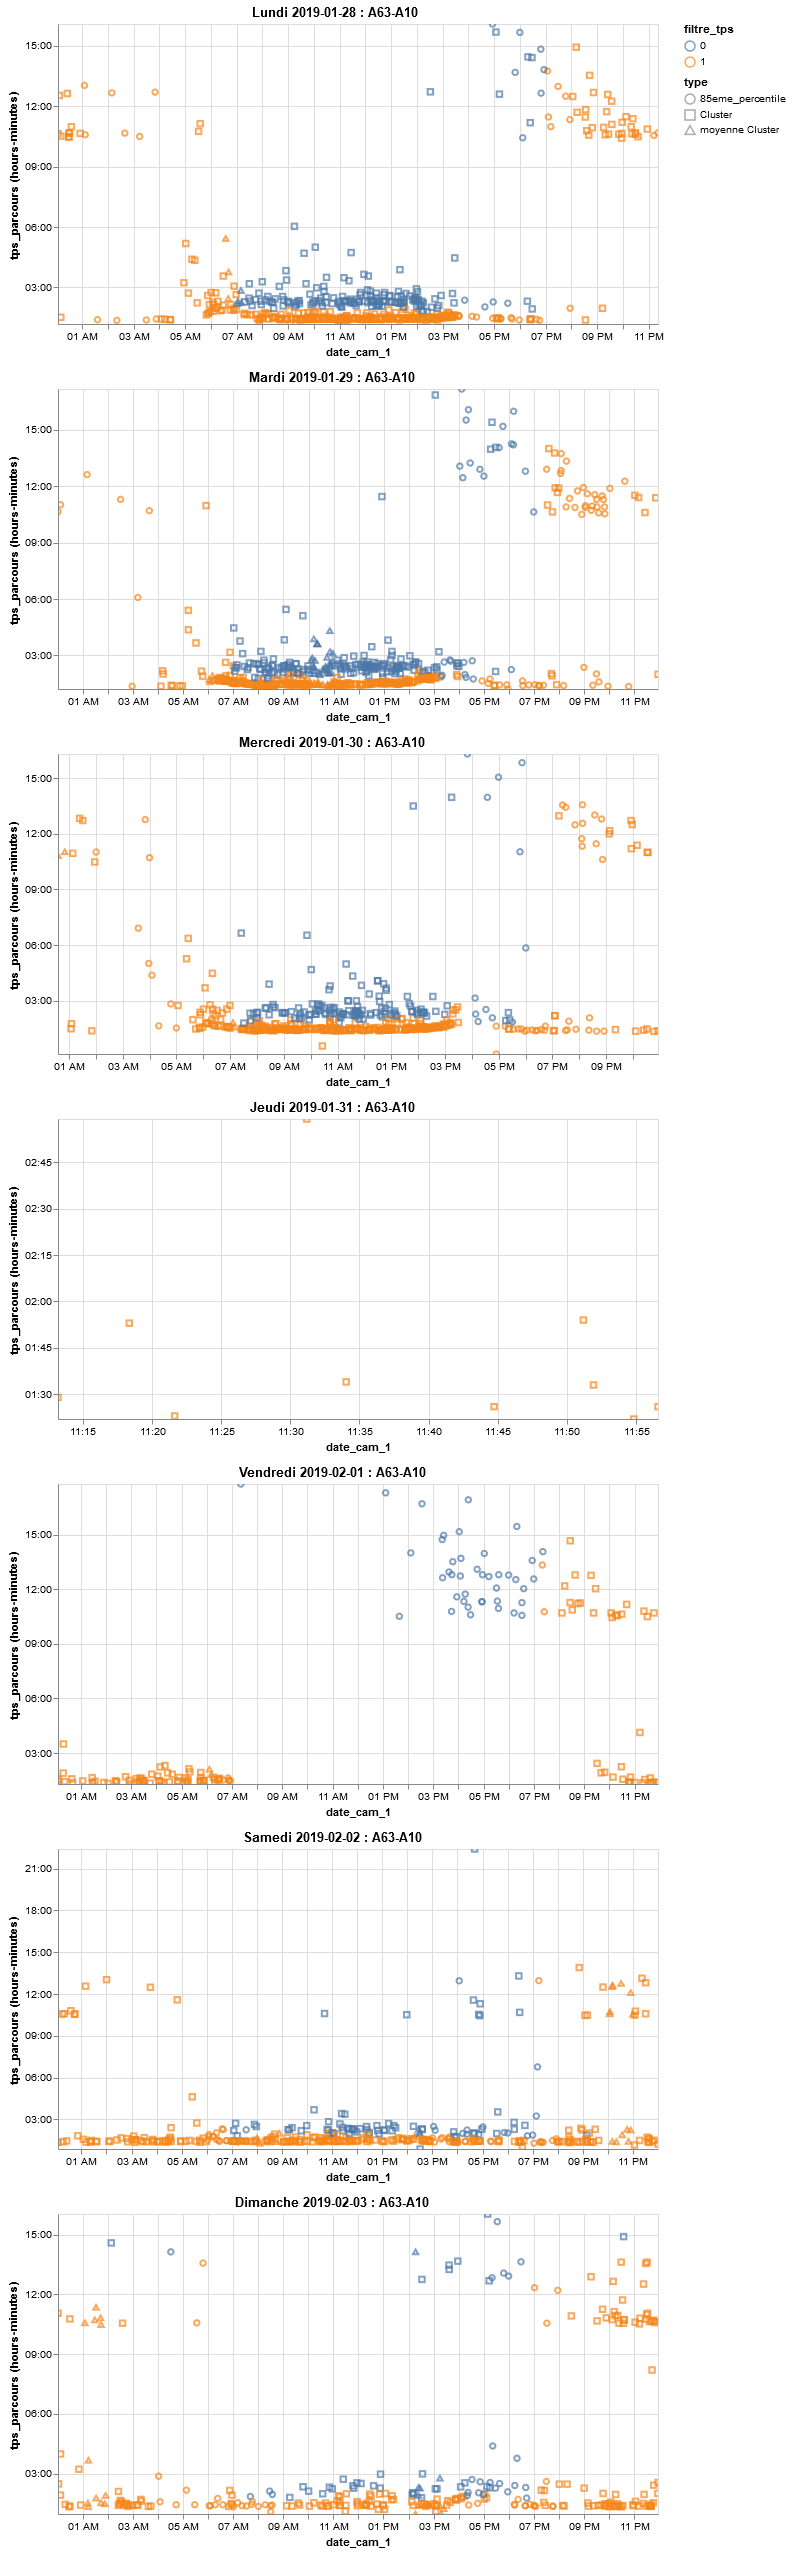

In [13]:
#exemple de visu sur 7 jours
t.graph_transit_filtre_multiple(df_transit_avec_filtre, 
                                '2019-01-28 00:00:00', '2019-01-28 23:59:59', 'A63-A10', 7)

In [10]:
#filtrer le df : 
dico_od_final=df_transit_avec_filtre.loc[df_transit_avec_filtre['filtre_tps']==1]

### 2.2.3. Correction des trajets depuis ou vers A660 relatifs à A63
> Il s'agit de corriger les trajets référencé depouis ou vers A660, alors que le vehicules a du passer sur A63 aussi.<br> plusieurs cas : 
- Passer sur A660 et vu avant ou apres sur A63
- Passer que sur A660 dans le sens nord sud puis sud-Nord, avec une immat déja vudans les plaques de transit et plus de 1jours d'ecart entre les passages

In [ ]:
%time df_od_corrige=t.correction_trajet(df_3semaines, dico_od)

c:\users\martin\appdata\local\programs\python\python37\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [ ]:
#pour retrouver les trajets corrigé : 
dic_od_corrige.loc[dic_od_corrige['correction_o_d']==True]

### 2.2.4. extrapolation des trajets non complets
> pour les véhicules qui ont déja été identifié comme faisant du transit

In [11]:
#detreminer les passages non_transit (ne peut pas etre fait dans la fonction loc_trajet_global)
df_temp=df_3semaines.loc[pd.to_datetime('2019-01-28 00:00:00'):]
df_non_transit=df_temp.loc[(~df_temp.head(100000).reset_index().set_index(['created','camera_id','immat']).index.isin(
dico_passag.set_index(['created','camera_id','immat']).index.tolist()))]

In [12]:
#grouper les passage transit, associer le nombre de fois où ils ont passés puis ne conserver que ceux qui sont passé au moins 2 fois
df_transit_nb_passage=dico_od_final.groupby(['immat','o_d'])['l'].count().reset_index().rename(columns={'l':'Nb_occ'})
df_immat_transit_nb_passage_sup2=df_transit_nb_passage.loc[df_transit_nb_passage['Nb_occ']>=2]
#identifier les doucblons : tel que présente le fichier présente bcp d'immat en double avec par exempele les o_d A660-N10 puis N10-A660.
#or tout les trajets finissant par A660 ou A63 sont déja traites plus haut, donc on les vire
#df_immat_transit_nb_passage_sup2.loc[df_immat_transit_nb_passage_sup2.duplicated('immat',False)].sort_values('immat')
df_filtre_A63=df_immat_transit_nb_passage_sup2.loc[df_immat_transit_nb_passage_sup2.apply(lambda x : x['o_d'].split('-')[1] not in ['A660','A63'],axis=1)]
df_filtre_A63.loc[df_filtre_A63.duplicated('immat',False)].sort_values('immat')

,immat,o_d,Nb_occ
1170,059786d8d37f2f2d093fff027ce3fc30f3fedb33,A63-N10,2
1172,059786d8d37f2f2d093fff027ce3fc30f3fedb33,N10-A62,2
1501,07534e7e06aedb857f690012a59fad3afa34387c,A89-N10,2
1502,07534e7e06aedb857f690012a59fad3afa34387c,N10-A89,2
3804,129eb947bc5184e1261304b0ea8ff9169c0b6139,A62-N10,2
3805,129eb947bc5184e1261304b0ea8ff9169c0b6139,N10-A62,2
7568,252248c29a533a491b1fc51d0bd65c287b7dd370,A10-A62,3
7569,252248c29a533a491b1fc51d0bd65c287b7dd370,A62-A10,2
11361,386003fd5500b168a547c3ca30f2ab00f6a9644c,N10-A62,5
11360,386003fd5500b168a547c3ca30f2ab00f6a9644c,A62-N10,2


In [76]:
#adaptation de la fonction loc_trajet_global aux donnés icomplete : seul le fichier de trajet change !!!
#par contre, pour obtenir la liste des passage de transit il faut d'abord vérifier que les immats retenues sont bien des immat déjà identifées en transit sur cet o_d
"""
fonction de detection des trajets pour tous les destinations possibles de la camera 1 du constrcuteur.
Nécessite l'utilisation de la variable module liste_complete_trajet qui contient tous les trajets possible en entree-sortie
En sortie : 
    df_transit : pandas dataframe conteant les mm colonnes que pour direct et indirects
    df_passag_transit : pandas dataframe conteant les passages considérés en transit

"""
def test_unicite_type(liste_l, mode='1/2'):
        """test pour voir si un vehicule a ete toujours vu de la mme façon ou non
           en entre : liste de valeur de l (qui traduit si c'est u pl ou non) iisues d'une df
           en sortie : integer 0  ou 1 ou -1
           """ 
        if mode=='unique' : 
            if len(set(liste_l))==1 :
                return liste_l[0]
            else : 
                return -1
        elif mode=='1/2' :
            if any(liste_l)==1 : 
                return 1
            else : 
                return -1
        elif mode=='aucun' :
            return 1
def filtrer_passage(liste, df_liste_trajet,cam) :
    """
    Récuperer les cameras qui correpondent à un trajet
    en entre : liste : tuple des cameras associée à une immat
               df_liste_trajet : dataframe des trajets pssibles issus de liste_complete_trajet
    en sortie : liste des cameras retenues dans le trajet
    """
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste[:len(liste_cams)]
    else : return liste

def recuperer_date_cam2(liste,liste_created,df_liste_trajet,cam):
    """
    Récuperer les horaires de passage des cameras qui correpondent à un trajet
    en entre : liste : tuple des cameras associée à une immat
               liste_created : tuple des horodate associées à une immat
               df_liste_trajet : dataframe des trajets pssibles issus de liste_complete_trajet
    en sortie : liste des horodates retenues dans le trajet
    """
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste_created[len(liste_cams)-1]
    else : return liste_created[-1]
date_debut=pd.to_datetime('2019-01-28 08:00:00')
date_fin=pd.to_datetime('2019-01-28 09:00:00')
df_filtre=None
camera1=15
#on limite le nb d'objet entre les 2 heures de depart
df_duree=df_non_transit.loc[date_debut:date_fin]
if df_duree.empty : 
   raise PasDePlError() 
if isinstance(df_filtre,pd.DataFrame) : 
    df_duree=filtrer_df(df_duree,df_filtre)
#on trouve les veh passés cameras 1
df_duree_cam1=df_duree.loc[df_duree.loc[:,'camera_id']==camera1]
if df_duree_cam1.empty : 
   raise PasDePlError() 
#on recupere ces immat aux autres cameras
df_duree_autres_cam=df_non_transit.loc[(df_non_transit.loc[:,'immat'].isin(df_duree_cam1.loc[:,'immat']))]
groupe=(df_duree_autres_cam.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x), 'l': lambda x : test_unicite_type(list(x),mode='1/2'),
                                                                               'created':lambda x: tuple(x)}))
groupe_pl=groupe.loc[groupe['l']==1].copy() #on ne garde que les pl
if groupe_pl.empty :
    raise PasDePlError()
groupe_pl['camera_id']=groupe_pl.apply(lambda x : filtrer_passage(x['camera_id'],liste_trajet_incomplet,camera1),axis=1)#on filtre les cameras selon la liste des trajets existants
groupe_pl['created']=groupe_pl.apply(lambda x : recuperer_date_cam2(x['camera_id'],x['created'],liste_trajet_incomplet,camera1),axis=1)#on recupère les datetimede passages correspondants
df_ts_trajets=(groupe_pl.reset_index().merge(liste_trajet_incomplet[['cameras','origine','destination']],right_on='cameras', left_on='camera_id').
               rename(columns={'created':'date_cam_2'}).drop('camera_id',axis=1))#on récupère les infos par jointure sur les cameras
if df_ts_trajets.empty :
    raise PasDePlError()
df_ts_trajets['o_d']=df_ts_trajets.apply(lambda x : x['origine']+'-'+x['destination'],axis=1)
df_agrege=df_duree_cam1.reset_index().merge(df_ts_trajets,on='immat').drop(['camera_id', 'l_x','fiability'],axis=1).rename(columns={'l_y':'l','created':'date_cam_1'})
df_agrege['tps_parcours']=df_agrege.apply(lambda x : x.date_cam_2-x.date_cam_1, axis=1)
df_agrege=df_agrege.loc[df_agrege['date_cam_2'] > df_agrege['date_cam_1']]#pour les cas bizarres de plaques vu a qq minutes d'intervalle au sein d'une même heure
if df_agrege.empty :
    raise PasDePlError()

In [46]:
#regrouper les pl
groupe_pl,df_duree_cam1,df_duree_autres_cam=t.grouper_pl(df_3semaines.loc[pd.to_datetime('2019-01-28 08:00:00'):pd.to_datetime('2019-01-29 02:00:00')]
                                                                          , pd.to_datetime('2019-01-28 08:00:00'), pd.to_datetime('2019-01-28 09:00:00'), 15, '1/2',dico_passag)

In [47]:
#le pb c'est qu epour le trajet qui s'arrete sur Rocade Ouest, le PL est susceptible d'aller soit sur A89 soit sur N10.
#on doit donc faire une jointure sur l'immat pour connaitre ses o_d possibles
#1. Trouver les immat de groupe PL concernées par du transit
groupe_pl_transit=groupe_pl.merge(df_filtre_A63, left_index=True, right_on='immat').rename(columns={'o_d':'o_d_immat'})
groupe_pl_transit

,camera_id,l,created,immat,o_d_immat,Nb_occ
14277,"(15,)",1,"(2019-01-28 08:29:55,)",46d78a9079503c1324229a473a50a8a501985387,A660-N10,2
27814,"(15, 19, 4, 18, 13)",1,"(2019-01-28 08:44:15, 2019-01-28 10:05:29, 2019-01-28 10:25:59, 2019-01-28 15:17:45, 2019-01-28 15:48:23)",8ba94bf6d64f877ae0ddd602eb52566ec39b7df3,A63-N10,2
44351,"(3, 19, 9, 19, 13, 15, 13, 18, 10, 2, 8, 5, 5, 13, 10, 9, 15, 15, 13, 5, 12, 5, 4, 15, 15, 3, 3, 5, 5, 4, 3, 4, 15, 4, 6, 8, 15, 15, 5, 5, 15, 5, 9, 10, 4, 10, 3, 3, 1, 13, 5, 15, 9, 5, 18, 13, 4, 10, 5, 4, 10, 18, 15, 3, 6, 6, 5, 7, 9, 11, 3, 15, 15, 8, 13, 18, 13, 8, 13, 19, 9, 19, 3, 10, 18, 15, 13, 3, 19, 4, 19, 13, 6, 4, 8, 5, 3, 4, 19, 3, ...)",1,"(2019-01-28 08:00:14, 2019-01-28 08:02:03, 2019-01-28 08:02:35, 2019-01-28 08:02:37, 2019-01-28 08:02:39, 2019-01-28 08:03:43, 2019-01-28 08:04:40, 2019-01-28 08:06:03, 2019-01-28 08:06:41, 2019-01-28 08:06:57, 2019-01-28 08:07:14, 2019-01-28 08:09:05, 2019-01-28 08:09:09, 2019-01-28 08:09:34, 2019-01-28 08:09:37, 2019-01-28 08:11:12, 2019-01-28 08:11:17, 2019-01-28 08:13:29, 2019-01-28 08:14:35, 2019-01-28 08:15:56, 2019-01-28 08:16:12, 2019-01-28 08:19:47, 2019-01-28 08:20:29, 2019-01-28 08:20:47, 2019-01-28 08:20:54, 2019-01-28 08:21:19, 2019-01-28 08:21:36, 2019-01-28 08:23:38, 2019-01-28 08:23:39, 2019-01-28 08:24:27, 2019-01-28 08:27:13, 2019-01-28 08:27:13, 2019-01-28 08:28:09, 2019-01-28 08:30:39, 2019-01-28 08:30:53, 2019-01-28 08:34:15, 2019-01-28 08:37:22, 2019-01-28 08:38:11, 2019-01-28 08:39:50, 2019-01-28 08:42:51, 2019-01-28 08:43:53, 2019-01-28 08:45:03, 2019-01-28 08:46:35, 2019-01-28 08:49:26, 2019-01-28 08:49:55, 2019-01-28 08:52:12, 2019-01-28 08:53:42, 2019-01-...",de8c2faf3ff92ef10bfbfac11738899cf3729aee,A62-N10,2
44352,"(3, 19, 9, 19, 13, 15, 13, 18, 10, 2, 8, 5, 5, 13, 10, 9, 15, 15, 13, 5, 12, 5, 4, 15, 15, 3, 3, 5, 5, 4, 3, 4, 15, 4, 6, 8, 15, 15, 5, 5, 15, 5, 9, 10, 4, 10, 3, 3, 1, 13, 5, 15, 9, 5, 18, 13, 4, 10, 5, 4, 10, 18, 15, 3, 6, 6, 5, 7, 9, 11, 3, 15, 15, 8, 13, 18, 13, 8, 13, 19, 9, 19, 3, 10, 18, 15, 13, 3, 19, 4, 19, 13, 6, 4, 8, 5, 3, 4, 19, 3, ...)",1,"(2019-01-28 08:00:14, 2019-01-28 08:02:03, 2019-01-28 08:02:35, 2019-01-28 08:02:37, 2019-01-28 08:02:39, 2019-01-28 08:03:43, 2019-01-28 08:04:40, 2019-01-28 08:06:03, 2019-01-28 08:06:41, 2019-01-28 08:06:57, 2019-01-28 08:07:14, 2019-01-28 08:09:05, 2019-01-28 08:09:09, 2019-01-28 08:09:34, 2019-01-28 08:09:37, 2019-01-28 08:11:12, 2019-01-28 08:11:17, 2019-01-28 08:13:29, 2019-01-28 08:14:35, 2019-01-28 08:15:56, 2019-01-28 08:16:12, 2019-01-28 08:19:47, 2019-01-28 08:20:29, 2019-01-28 08:20:47, 2019-01-28 08:20:54, 2019-01-28 08:21:19, 2019-01-28 08:21:36, 2019-01-28 08:23:38, 2019-01-28 08:23:39, 2019-01-28 08:24:27, 2019-01-28 08:27:13, 2019-01-28 08:27:13, 2019-01-28 08:28:09, 2019-01-28 08:30:39, 2019-01-28 08:30:53, 2019-01-28 08:34:15, 2019-01-28 08:37:22, 2019-01-28 08:38:11, 2019-01-28 08:39:50, 2019-01-28 08:42:51, 2019-01-28 08:43:53, 2019-01-28 08:45:03, 2019-01-28 08:46:35, 2019-01-28 08:49:26, 2019-01-28 08:49:55, 2019-01-28 08:52:12, 2019-01-28 08:53:42, 2019-01-...",de8c2faf3ff92ef10bfbfac11738899cf3729aee,A63-A10,3
44353,"(3, 19, 9, 19, 13, 15, 13, 18, 10, 2, 8, 5, 5, 13, 10, 9, 15, 15, 13, 5, 12, 5, 4, 15, 15, 3, 3, 5, 5, 4, 3, 4, 15, 4, 6, 8, 15, 15, 5, 5, 15, 5, 9, 10, 4, 10, 3, 3, 1, 13, 5, 15, 9, 5, 18, 13, 4, 10, 5, 4, 10, 18, 15, 3, 6, 6, 5, 7, 9, 11, 3, 15, 15, 8, 13, 18, 13, 8, 13, 19, 9, 19, 3, 10, 18, 15, 13, 3, 19, 4, 19, 13, 6, 4, 8, 5, 3, 4, 19, 3, ...)",1,"(2019-01-28 08:00:14, 2019-01-28 08:02:03, 2019-01-28 08:02:35, 2019-01-28 08:02:37, 2019-01-28 08:02:39, 2019-01-28 08:03:43, 2019-01-28 08:04:40, 2019-01-28 08:06:03, 2019-01-28 08:06:41, 2019-01-28 08:06:57, 2019-01-28 08:07:14, 2019-01-28 08:09:05, 2019-01-28 08:09:09, 2019-01-28 08:09:34, 2019-01-28 08:09:37, 2019-01-28 08:11:12, 2019-01-28 08:11:17, 2019-01-28 08:13:29, 2019-01-28 08:14:35, 2019-01-28 08:15:56, 2019-01-28 08:16:12, 2019-01-28 08:19:47, 2019-01-28 08:20:2

In [56]:
#2.filtrer selon les trajets possibles
trajets_possibles=(t.filtre_et_forme_passage(15,groupe_pl_transit, liste_trajet_incomplet, df_duree_cam1).drop(
                   'index',axis=1).rename(columns={'o_d':'o_d_liste_trajet'}))
df_immats=df_3semaines.loc[df_3semaines.immat.isin(trajets_possibles.immat.unique().tolist())]
trajets_possibles

,date_cam_1,immat,state,l,date_cam_2,o_d_immat,Nb_occ,cameras,origine,destination,o_d_liste_trajet,tps_parcours
0,2019-01-28 08:44:15,8ba94bf6d64f877ae0ddd602eb52566ec39b7df3,ES,1,2019-01-28 10:25:59,A63-N10,2,"(15, 19, 4)",A63,N10,A63-N10,01:41:44
1,2019-01-28 08:44:15,8ba94bf6d64f877ae0ddd602eb52566ec39b7df3,ES,1,2019-01-28 10:25:59,A63-N10,2,"(15, 19, 4)",A63,A89,A63-A89,01:41:44


In [92]:
#retrouver les cameras et date avant / apres un passage
def cam_voisines(immat, date, camera) :
    """
    Retrouver les dates et camera de passages d'un vehicule avant et apres un passage donne
    en entree : 
        immat : string : immatribualtion
        date : string : date de passage
        camera : cam de passage
        df_immat : df des immats concernees (limiter le df_3semainee)
    """
    passage_immat=df_3semaines.loc[df_3semaines['immat']==immat].reset_index().copy()
    idx=passage_immat.loc[(passage_immat['created']==date) & (passage_immat['camera_id']==camera)].index
    cam_suivant, date_suivant=passage_immat.shift(-1).iloc[idx]['camera_id'].values[0], passage_immat.shift(-1).iloc[idx]['created'].values[0]
    cam_precedent, date_precedent=passage_immat.shift(1).iloc[idx]['camera_id'].values[0], passage_immat.shift(1).iloc[idx]['created'].values[0]
    return cam_suivant,date_suivant, cam_precedent,date_precedent

toto=trajets_possibles.apply(lambda x : cam_voisines(x['immat'], x['date_cam_2'],x['cameras'][-1]),axis=1, result_type='expand')
toto.columns=['cam_suivant','date_suivant','cam_precedent','date_precedent']
pd.concat([trajets_possibles,toto],axis=1)

,date_cam_1,immat,state,l,date_cam_2,o_d_immat,Nb_occ,cameras,origine,destination,o_d_liste_trajet,tps_parcours,cam_suivant,date_suivant,cam_precedent,date_precedent
0,2019-01-28 08:44:15,8ba94bf6d64f877ae0ddd602eb52566ec39b7df3,ES,1,2019-01-28 10:25:59,A63-N10,2,"(15, 19, 4)",A63,N10,A63-N10,01:41:44,18.0,2019-01-28 15:17:45,19.0,2019-01-28 10:05:29
1,2019-01-28 08:44:15,8ba94bf6d64f877ae0ddd602eb52566ec39b7df3,ES,1,2019-01-28 10:25:59,A63-N10,2,"(15, 19, 4)",A63,A89,A63-A89,01:41:44,18.0,2019-01-28 15:17:45,19.0,2019-01-28 10:05:29


**EN COURS :** 
1. il faut qu'à patir de la liste des passage en transit possible, on puisse faire la diff entre les trajets susceptibles (exempel: 15,19,4 peut envoyer soit sur A89 ou N10. Si l'immat a deja pris les deux plus de deux fois on la retrouve 2 fois dans la liste des immats), donc : il faut regarder la camera suivante (que l'on a dans la df ci -dessus..)
1. regarder la camera suivante : si c'est la camera sens inverse (A89, A62, N10) on est sur que c'est bien du transit
1. filtrer sselon les temps de parcours
1. ajouter aux o_d précédents
1. ajouter à la liste des passages de transit

In [76]:
#pour obtenir la liste des passagesrelevant de trajets de transits :
#limitation des données des cameras par jointures
df_joint_passag_transit=df_agrege.merge(df_duree_autres_cam.reset_index(), on='immat')
df_passag_transit1=df_joint_passag_transit.loc[(df_joint_passag_transit.apply(lambda x : x['camera_id'] in x['cameras'], axis=1))]
df_passag_transit=(df_passag_transit1.loc[df_passag_transit1.apply(lambda x : x['date_cam_1']<=x['created']<=x['date_cam_2'], axis=1)]
                [['created','camera_id','immat','fiability','l_y','state_x']].rename(columns={'l_y':'l','state_x':'state'}))

In [77]:
df_passag_transit

,created,camera_id,immat,fiability,l,state
0,2019-01-28 08:03:31,15,d886df972266faa933c620d4dbc7c68ab0f64fab,99,-1,ES
1,2019-01-28 08:34:49,19,d886df972266faa933c620d4dbc7c68ab0f64fab,89,1,ES
2,2019-01-28 09:33:06,4,d886df972266faa933c620d4dbc7c68ab0f64fab,89,1,ES
3,2019-01-28 08:03:31,15,d886df972266faa933c620d4dbc7c68ab0f64fab,99,-1,ES
4,2019-01-28 08:34:49,19,d886df972266faa933c620d4dbc7c68ab0f64fab,89,1,ES
5,2019-01-28 09:33:06,4,d886df972266faa933c620d4dbc7c68ab0f64fab,89,1,ES
6,2019-01-28 08:03:43,15,ca39aa7d9bfd1f9898ee35157679fa2f895c4f0e,99,1,FR
7,2019-01-28 08:36:49,19,ca39aa7d9bfd1f9898ee35157679fa2f895c4f0e,99,1,FR
8,2019-01-28 08:10:08,15,3e15580eccf90999666e72f0b9b295d46e755c9c,99,-1,ES
9,2019-01-28 08:42:10,19,3e15580eccf90999666e72f0b9b295d46e755c9c,99,0,ES


In [181]:



df_ts_trajets=(groupe_pl.reset_index().merge(liste_complete_trajet[['cameras','origine','destination']],right_on='cameras', left_on='camera_id').
               rename(columns={'created':'date_cam_2'}).drop('camera_id',axis=1))#on récupère les infos par jointure sur les cameras
if df_ts_trajets.empty :
    raise PasDePlError()
df_ts_trajets['o_d']=df_ts_trajets.apply(lambda x : x['origine']+'-'+x['destination'],axis=1)
df_agrege=df_duree_cam1.reset_index().merge(df_ts_trajets,on='immat').drop(['camera_id', 'l_x','fiability'],axis=1).rename(columns={'l_y':'l','created':'date_cam_1'})
df_agrege['tps_parcours']=df_agrege.apply(lambda x : x.date_cam_2-x.date_cam_1, axis=1)
df_agrege=df_agrege.loc[df_agrege['date_cam_2'] > df_agrege['date_cam_1']]#pour les cas bizarres de plaques vu a qq minutes d'intervalle au sein d'une même heure

if df_agrege.empty :
    raise PasDePlError()

#pour obtenir la liste des passagesrelevant de trajets de transits :
#limitation des données des cameras par jointures
df_joint_passag_transit=df_agrege.merge(df_duree_autres_cam.reset_index(), on='immat')
df_passag_transit1=df_joint_passag_transit.loc[(df_joint_passag_transit.apply(lambda x : x['camera_id'] in x['cameras'], axis=1))]
df_passag_transit=(df_passag_transit1.loc[df_passag_transit1.apply(lambda x : x['date_cam_1']<=x['created']<=x['date_cam_2'], axis=1)]
                [['created','camera_id','immat','fiability','l_y','state_x']].rename(columns={'l_y':'l','state_x':'state'}))

#et par opposition la liste des passages ne relevant pas des trajets de transit        
return df_agrege,df_passag_transit

In [181]:
#adaptation de la fonction transit_temps_complet : pour chaque date regrouper les cameras et identifés les immat relatives au transit et qui ont un trajet qui collent
date_debut='2019-01-28 00:00:00'
date_fin=(pd.to_datetime(date_debut)+pd.Timedelta(days=nb_jours)).strftime('%Y-%m-%d')

    for date, duree in t.creer_liste_date(date_debut, nb_jours) :
        if date.weekday()==5 : # si on est le semadi on laisse la journee de dimanche passer et le pl repart
            df_journee=df_3semaines.loc[date:date+pd.Timedelta(hours=32)]
        else : 
            df_journee=df_3semaines.loc[date:date+pd.Timedelta(hours=18)]
        if date.minute==0 : print(f"date : {date} debut_traitement : {dt.datetime.now()}")
        for cameras in zip([15,10,8],range(6)) :

In [55]:
df_non_transit.head(5)

,camera_id,immat,fiability,l,state
created,,,,,
2019-01-28 00:00:00,5,d67f03dae600b3866a4d56d0eb2e2dbd6718097a,99,0,ES
2019-01-28 00:00:02,5,d1724cc8fed2c21e3700b59fcdfc0b6b0720700f,99,0,ES
2019-01-28 00:00:05,5,4bef1bac1f9833d59d40cbf266f5cc8c919114b8,78,0,ES
2019-01-28 00:00:07,10,c95435801c64f6ef7530afc9fa9d0ae4ac61cf41,57,0,FR
2019-01-28 00:00:08,18,3fc7ef985d47b567d2402c754eb13144ff922c4b,59,0,FR


In [181]:
dico_od_final.loc[dico_od_final['immat']=='004b4e6b2c37ccda342d34632a4ad06be1f63467']

,date_cam_1,immat,state,l,date_cam_2,cameras,origine,destination,o_d,tps_parcours,period,date,temps,type,tps_parcours_theoriq,filtre_tps
17482,2019-01-30 18:16:14,004b4e6b2c37ccda342d34632a4ad06be1f63467,ES,1,2019-01-30 19:33:50,"(6, 3, 18, 13)",N10,A63,N10-A63,01:17:36,2019-01-30 18:15,2019-01-30 18:15:00,01:30:58,Cluster,01:04:01.001000,1
28751,2019-02-04 05:55:41,004b4e6b2c37ccda342d34632a4ad06be1f63467,ES,1,2019-02-04 07:31:25,"(15, 19, 4, 5, 11)",A63,A10,A63-A10,01:35:44,2019-02-04 05:00,2019-02-04 05:00:00,01:35:26,Cluster,01:30:14.634000,1


In [158]:
groupe_pl['camera_id']=groupe_pl.apply(lambda x : filtrer_passage(x['camera_id'],liste_complete_trajet,camera1),axis=1)#on filtre les cameras selon la liste des trajets existants
groupe_pl['created']=groupe_pl.apply(lambda x : recuperer_date_cam2(x['camera_id'],x['created'],liste_complete_trajet,camera1),axis=1)

In [163]:
len(df_3semaines)

5393118

In [167]:
df_non_transit.head(5)

,camera_id,immat,fiability,l,state
created,,,,,
2019-01-28 00:00:00,5,d67f03dae600b3866a4d56d0eb2e2dbd6718097a,99,0,ES
2019-01-28 00:00:01,19,7e35f81e0a03468736e42733b5e5efd4cbb0d29d,99,0,PT
2019-01-28 00:00:02,5,d1724cc8fed2c21e3700b59fcdfc0b6b0720700f,99,0,ES
2019-01-28 00:00:05,5,4bef1bac1f9833d59d40cbf266f5cc8c919114b8,78,0,ES
2019-01-28 00:00:07,10,c95435801c64f6ef7530afc9fa9d0ae4ac61cf41,57,0,FR


In [161]:
df_non_transit=df_3semaines.loc[(~df_3semaines.reset_index().set_index(['created','camera_id','immat']).index.isin(
dico_passag.set_index(['created','camera_id','immat']).index.tolist()))]

CREER LE TABLEAU DE MATRICE O-D

In [10]:
#MATRICE O-D !!II!
pd.pivot_table(dico_od,values='l', index='origine', columns='destination',aggfunc='count', margins=True )

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NaN,7565.0,7320.0,4299.0,658.0,NaN,19842
A62,2988.0,NaN,537.0,1381.0,1304.0,3222.0,9432
A63,7015.0,349.0,NaN,NaN,1712.0,32065.0,41141
A660,3052.0,1558.0,NaN,NaN,2270.0,7867.0,14747
A89,631.0,1672.0,2253.0,2616.0,NaN,1832.0,9004
N10,NaN,4470.0,27132.0,7558.0,1275.0,NaN,40435
All,13686.0,15614.0,37242.0,15854.0,7219.0,44986.0,134601


POURCENTAGE PL PAR PLAGE HORAIRE ET CAMERA

In [432]:
#isoler pl source
groupe_tv_type_simple=df_journee.groupby('immat')['l'].apply(lambda x:test_unicite_type(list(x),mode='1/2')).reset_index().drop_duplicates('immat')
df_pl=df_journee.join(groupe_tv_type_simple.loc[groupe_tv_type_simple['l']==1].set_index('immat'),on='immat',how='inner',rsuffix='_right')
df_pl.set_index('created',inplace=True)

#obtenir les nb de pl par heure et par camera sur la source
df_synthese_pl_tot=df_pl.groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_tot'})
df_synthese_pl_transit=dico_passag.set_index('created').groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_transit'})
df_pct_pl_transit=pd.concat([df_synthese_pl_tot,df_synthese_pl_transit], axis=1, join='inner')
df_pct_pl_transit.columns=[['nb_pl_tot','nb_pl_transit']]
df_pct_pl_transit['pct_pl_transit']=df_pct_pl_transit.apply(lambda x : float(x['nb_pl_transit'])*100 / x['nb_pl_tot'] ,axis=1)
df_pct_pl_transit

In [ ]:
pct_pl=t.pourcentage_pl_camera('2019-01-28 00:00:00', 1,df_3semaines.reset_index(),dico_passag)
pct_pl

VERIFICATION

In [57]:
#retrouver une immatriculatiob dans les données completes
df_3semaines.loc[df_3semaines['immat']=='8ba94bf6d64f877ae0ddd602eb52566ec39b7df3']

In [84]:
#retrouver les cameras et date avant / apres un passage
def cam_voisines(immat, date, camera, df_immat) :
    """
    Retrouver les dates et camera de passages d'un vehicule avant et apres un passage donne
    en entree : 
        immat : string : immatribualtion
        date : string : date de passage
        camera : cam de passage
        df_immat : df des immats concernees (limiter le df_3semainee)
    """
    passage_immat=df_immat.loc[df_immat['immat']==immat].reset_index().copy()
    idx=passage_immat.loc[(passage_immat['created']==date) & (passage_immat['camera_id']==camera)].index
    cam_suivant, date_suivant=passage_immat.shift(-1).iloc[idx]['camera_id'].values[0], passage_immat.shift(-1).iloc[idx]['created'].values[0]
    cam_precedent, date_precedent=passage_immat.shift(1).iloc[idx]['camera_id'].values[0], passage_immat.shift(1).iloc[idx]['created'].values[0]
    return cam_suivant,date_suivant, cam_precedent,date_precedent


In [139]:

toto=df_3semaines.loc[pd.to_datetime('2019-02-01 09:00:00'):pd.to_datetime('2019-02-04 22:00:00')]
toto.loc[toto['camera_id']==11]

,camera_id,immat,fiability,l,state
created,,,,,
2019-02-01 23:00:51,11,a1a9148b72647a6aeb97219e0ece325b04a18c18,99,0,FR
2019-02-01 23:01:35,11,0a6309f51c40e3dba00b441dbb8c1a5a784e4c6a,99,0,FR
2019-02-01 23:01:47,11,bd9b1bc1bd72453a41baae0909a40aea0e009e4f,99,0,FR
2019-02-01 23:02:04,11,b2fe2ec5da89e6a74424375fdedd88ce4c83e87e,58,0,FR
2019-02-01 23:02:24,11,55dce112f48dc9811d985e9ed11b9d0ea7caf442,59,0,FR
2019-02-01 23:02:37,11,d9498bd1085e16e8e534abbc47f2ff78bacfdffe,99,0,FR
2019-02-01 23:04:15,11,9f45540c24b3534beb0beeae7d597de5f63f67ac,99,0,FR
2019-02-01 23:04:55,11,a895e9993249b44e116002dad11030555b53b657,99,0,ES
2019-02-01 23:05:28,11,6424572aa102be183ac14bcbcd1ded817fc1a79d,99,0,FR


In [54]:
# retrouver une immatriculatiob dans ledico o_d
dico_od.loc[dico_od['immat']=='b4a14d6f285826ae2d1d6042c7ab13e2d01b98d0']

,date_cam_1,immat,state,l,date_cam_2,cameras,origine,destination,o_d,tps_parcours,period
18,2019-01-29 07:44:45,b4a14d6f285826ae2d1d6042c7ab13e2d01b98d0,ES,1,2019-01-29 09:10:44,"(6, 18, 13)",N10,A63,N10-A63,01:25:59,2019-01-29 07:30


In [130]:
#verif a un horaire donne sur un trajet direct ou indirect ou global
#%time trajet_test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19],modeRegroupement='aucun')
"""%time test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19,4],typeTrajet='Indirect',
                     modeRegroupement='aucun')"""
test=t.trajet(df_3semaines.loc['2019-02-01 00:00:00':'2019-02-02 23:59:59'], '2019-02-01 09:00:00', 60, [15, 11],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')
test.df_transit.loc[test.df_transit['o_d']=='A63-A10']

,date_cam_1,immat,state,l,date_cam_2,cameras,origine,destination,o_d,tps_parcours


TESTS A LA MANO

In [240]:
#pour trouver un trajet direct (sans disticntion de type ou autre)
test2=t.trouver_passages_consecutif(df_3semaines, '2019-01-29 00:00:00', '2019-01-29 23:59:59', 15, 19)
#test2=test2.set_index('created_y').sort_index()

In [152]:
%%time
#pour test des fonctions de trajets global

def filtrer_passage(liste, df_liste_trajet,cam) :
    """
    Récuperer les cameras qui correpondent à un trajet
    """
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste[:len(liste_cams)]
    else : return liste

def recuperer_date_cam2(liste,liste_created,df_liste_trajet,cam):
    """
    Récuperer les horaires de passage des cameras qui correpondent à un trajet
    """
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste_created[len(liste_cams)-1]
    else : return liste_created[-1]
    
def test_unicite_type(liste_l, mode='unique'):
    """test pour voir si un vehicule a ete toujours vu de la mme façon ou non
       en entre : liste de valeur de l (qui traduit si c'est u pl ou non) iisues d'une df
       en sortie : integer 0  ou 1 ou -1
       """ 
    if mode=='unique' : 
        if len(set(liste_l))==1 :
            return liste_l[0]
        else : 
            return -1
    elif mode=='1/2' :
        if any(liste_l)==1 : 
            return 1
        else : 
            return -1

camera1, camera2=15,5
df=df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'].copy()
df_duree=df.loc['2019-01-29 08:00:00':'2019-01-29 09:00:00']
df_duree_cam1=df_duree.loc[df_duree.loc[:,'camera_id']==camera1]
df_duree_autres_cam=df.loc[(df.loc[:,'immat'].isin(df_duree_cam1.loc[:,'immat']))]
groupe=(df_duree_autres_cam.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x), 'l': lambda x : test_unicite_type(list(x),'1/2'),
                                                                               'created':lambda x: tuple(x)}))
groupe_pl=groupe.loc[groupe['l']==1].copy()
groupe_pl['camera_id']=groupe_pl.apply(lambda x : filtrer_passage(x['camera_id'],liste_complete_trajet,camera1),axis=1)#on filtre les cameras selon la liste des trajets existants
groupe_pl['created']=groupe_pl.apply(lambda x : recuperer_date_cam2(x['camera_id'],x['created'],liste_complete_trajet,camera1),axis=1)
df_ts_trajets=(groupe_pl.reset_index().merge(liste_complete_trajet[['cameras','origine','destination']],right_on='cameras', left_on='camera_id').
               rename(columns={'created':'date_cam_2'}).drop('camera_id',axis=1))
df_ts_trajets['o_d']=df_ts_trajets.apply(lambda x : x['origine']+'-'+x['destination'],axis=1)
df_agrege=df_duree_cam1.reset_index().merge(df_ts_trajets,on='immat').drop(['camera_id', 'l_x','state','fiability'],axis=1).rename(columns={'l_y':'l','created':'date_cam_1'})
df_agrege['tps_parcours']=df_agrege.apply(lambda x : x.date_cam_2-x.date_cam_1, axis=1)
df_agrege=df_agrege.loc[df_agrege['date_cam_2'] > df_agrege['date_cam_1']]

df_joint_passag_transit=df_agrege.merge(df_duree_autres_cam.reset_index(), on='immat')
df_passag_transit1=df_joint_passag_transit.loc[(df_joint_passag_transit.apply(lambda x : x['camera_id'] in x['cameras'], axis=1))]
df_passag_transit=(df_passag_transit1.loc[df_passag_transit1.apply(lambda x : x['date_cam_1']<=x['created']<=x['date_cam_2'], axis=1)]
                [['created','camera_id','immat','fiability','l_y','state']].rename(columns={'l_y':'l'}))

Wall time: 545 ms


In [156]:
df_duree.loc[(~df_duree.reset_index().set_index(['created','camera_id','immat']).index.isin(
df_passag_transit.reset_index().set_index(['created','camera_id','immat']).index.tolist()))
            & (df_duree['l']==1)]

,camera_id,immat,fiability,l,state
created,,,,,
2019-01-29 08:00:01,9,6ad0a4fb487133367f328eab8b4737ea84c57e58,68,1,FR
2019-01-29 08:00:02,5,61cac18dc72d18404997563a19189d285e113433,99,1,FR
2019-01-29 08:00:05,7,390a1e8c661e3d9d3fb2086f3bc0beaf881dfc03,99,1,FR
2019-01-29 08:00:09,8,8b6f7e6583598b8061f7336aaaed3f3f3566a373,99,1,FR
2019-01-29 08:00:09,6,1d1cf7e4631edd3577065938ff6ad877b878d38b,69,1,FR
2019-01-29 08:00:10,4,217b369e4e8671808451bdebc4470307fc39f116,99,1,FR
2019-01-29 08:00:12,4,0c8e7289d4c2f3211afdedfd22d16cb2e723b0f8,79,1,PL
2019-01-29 08:00:12,18,9dea2910588936cf9e9dc07043442b039f138e05,99,1,FR
2019-01-29 08:00:15,4,46b824be2bd8318edb555fe9e66c31c8ef1f3c02,99,1,FR


In [154]:
df_passag_transit

,created,camera_id,immat,fiability,l,state
0,2019-01-29 08:00:16,15,297caaae436d3f8ddf233000476038e3e4b68e94,99,-1,RO
1,2019-01-29 09:23:32,19,297caaae436d3f8ddf233000476038e3e4b68e94,99,1,RO
2,2019-01-29 09:45:03,4,297caaae436d3f8ddf233000476038e3e4b68e94,99,0,RO
3,2019-01-29 09:56:46,5,297caaae436d3f8ddf233000476038e3e4b68e94,99,0,RO
4,2019-01-29 08:00:23,15,a80e71eb1efa9b3928784d0f9a2b858720700a52,99,-1,ES
5,2019-01-29 09:04:52,19,a80e71eb1efa9b3928784d0f9a2b858720700a52,99,1,ES
6,2019-01-29 09:25:10,4,a80e71eb1efa9b3928784d0f9a2b858720700a52,99,0,ES
7,2019-01-29 09:36:21,5,a80e71eb1efa9b3928784d0f9a2b858720700a52,99,1,ES
11,2019-01-29 08:00:24,15,4b6193e6bde15a1f9147ac769d2e45f92835661c,100,-1,ES
12,2019-01-29 08:31:16,19,4b6193e6bde15a1f9147ac769d2e45f92835661c,89,1,ES


nb clusters = 1
tps parcours max : 0 days 02:26:52, final : 0 days 02:26:52


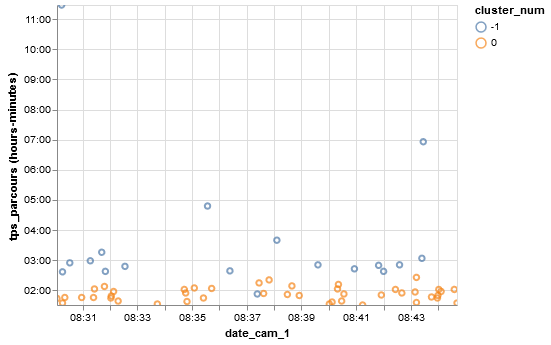

In [189]:
## pour tests des cluster
test=t.trajet(df_3semaines.loc['2019-01-31 00:00:00':'2019-02-01 23:59:59'], '2019-01-31 08:30:00', 15, [6, 13],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')
donnees=test.df_transit[test.df_transit['o_d']=='N10-A63'].copy()
donnees_src=donnees.loc[:,['date_cam_1','tps_parcours']].copy() #isoler les données necessaires
liste_valeur=donnees_src.tps_parcours.apply(lambda x : ((pd.to_datetime('2018-01-29')+x)-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()#convertir les temps en integer
liste_date=donnees_src.date_cam_1.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()
liste=[[liste_date[i],liste_valeur[i]] for i in range(len(liste_valeur))]
if len(liste_valeur)<0 : #si il n'y a pas bcp de pl on arrete ; pourraitfair l'objet d'un parametre
    raise ClusterError()
#mise en forme des données pour passer dans sklearn 
matrice=np.array(liste_valeur).reshape(-1, 1)
#faire tourner la clusterisation et recupérer le label (i.e l'identifiant cluster) et le nombre de cluster
clustering=DBSCAN(eps=1000, min_samples=len(liste_valeur)/4).fit(liste)
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"nb clusters = {n_clusters_}")
results = pd.DataFrame(pd.DataFrame([donnees_src.index,labels]).T)
results.columns = ['index_base', 'cluster_num']
results = pd.merge(results,donnees_src, left_on='index_base', right_index=True )
temp_parcours_max=results.loc[results.loc[:,'cluster_num']!=-1].groupby(['cluster_num'])['tps_parcours'].max().min()
temp_parcours_max2=temp_parcours_max
copie_df=results.copy()
copie_df.tps_parcours=pd.to_datetime('2018-01-29')+copie_df.tps_parcours
graph_tps_parcours = alt.Chart(copie_df).mark_point().encode(
                            x='date_cam_1',
                            y='hoursminutes(tps_parcours)', color='cluster_num:N',
                            tooltip='hoursminutes(tps_parcours)').interactive()
print(f'tps parcours max : {temp_parcours_max}, final : {temp_parcours_max2}')
graph_tps_parcours

TESTS

In [122]:
a660_n10=dico_od.loc[dico_od['o_d']=='N10-A63'].copy()
a660_n10=a660_n10[a660_n10.apply(lambda x : x['date_cam_1'].to_period('D')==pd.Period('2019-01-29',freq='D'), axis=1)].reset_index().drop('index', axis=1)
a660_n10.tps_parcours=pd.to_datetime('2018-01-28')+a660_n10.tps_parcours

In [47]:
dico_od_graph=dico_od.copy()
dico_od_graph.tps_parcours=pd.to_datetime('2019-01-29')+dico_od_graph.tps_parcours

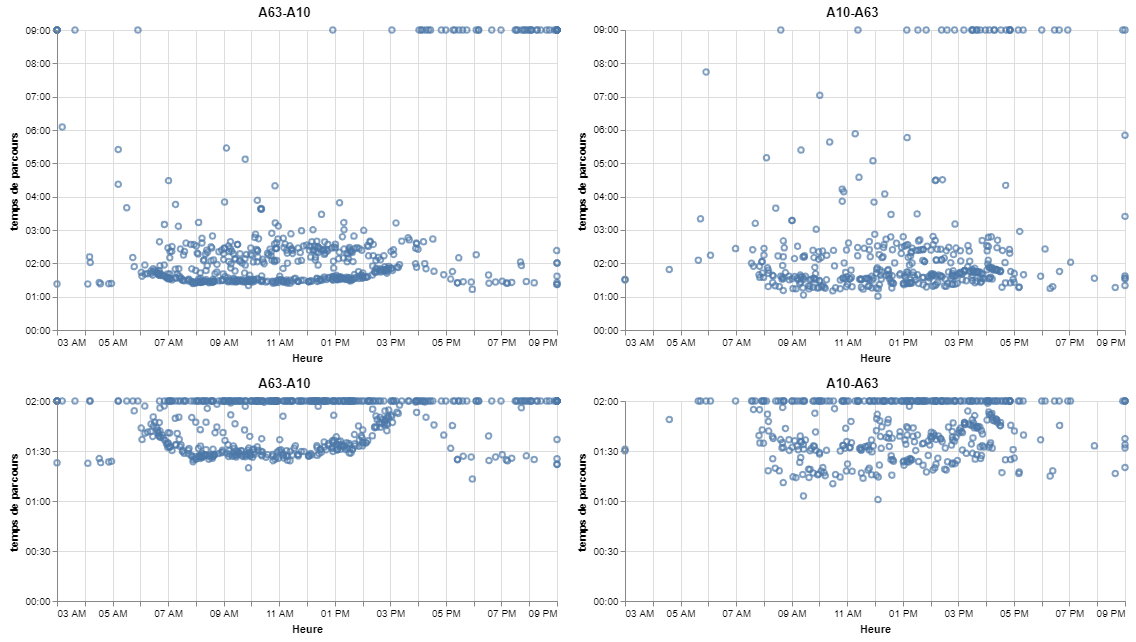

In [71]:
base_a63_n10 = alt.Chart(dico_od_graph.loc[dico_od_graph['o_d']=='A10-A63'], title='A10-A63').mark_point().encode(
                            x=alt.X('date_cam_1:T',title='Heure',scale=alt.Scale(domain=('2019-01-29 03:00:00','2019-01-29 21:00:00'),clamp=True))
                            )
up_a63_n10=base_a63_n10.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 09:00:00'),clamp=True))).properties(width=500, height=300)
low_a63_n10=base_a63_n10.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 02:00:00'),clamp=True))).properties(width=500, height=200)
a63_n10=alt.vconcat(up_a63_n10,low_a63_n10)

base_n10_a63 = alt.Chart(dico_od_graph.loc[dico_od_graph['o_d']=='A63-A10'], title='A63-A10').mark_point().encode(
                            x=alt.X('date_cam_1:T',title='Heure',scale=alt.Scale(domain=('2019-01-29 03:00:00','2019-01-29 21:00:00'),clamp=True))
                            )
up_n10_a63=base_n10_a63.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 09:00:00'),clamp=True))).properties(width=500, height=300)
low_n10_a63=base_n10_a63.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 02:00:00'),clamp=True))).properties(width=500, height=200)
n10_a63=alt.vconcat(up_n10_a63,low_n10_a63)
n10_a63|a63_n10

In [193]:
param_cluster=pd.DataFrame({'trajet':[('A10-A63','A89-A63','A62-A63','A10-A62','N10-A62','A89-A62','A10-A89','N10-A89','A10-A660','N10-A660','A89-A660','A62-A660'),
                        ('A10-A63','N10-A63','A89-A63','A62-A63','A10-A62','N10-A62','A89-A62','A10-A89','N10-A89','A10-A660','N10-A660','A89-A660','A62-A660'),
                        ('A63-A10','A63-N10','A63-A89','A63-A62','A62-A10','A62-N10','A62-A89','A89-A10','A89-N10','A660-A10','A660-N10','A660-A89','A660-A62'),
                        ('A63-A10','A63-N10','A63-A89','A63-A62','A62-A10','A62-N10','A62-A89','A89-A10','A89-N10','A660-A10','A660-N10','A660-A89','A660-A62'),
                        ('N10-A63')
                       ],
              'temps_etudie':[15,60,15,60,15],
              'delai':[600,1200,800,1000,1000],
              'nb_pt_min':[4,4,3,4,4]
             })
param_cluster.to_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\param_cluster.json', orient='index')

In [55]:
param_cluster=pd.read_json(r'E:\Boulot\lapi\param_cluster.json', orient='index')
param_cluster

,delai,nb_pt_min,temps_etudie,trajet
0,600,4,15,"[A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
1,1200,4,60,"[A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
2,800,3,15,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"
3,1000,4,60,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"


In [278]:
"""%time test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19,4],typeTrajet='Indirect',
                     modeRegroupement='aucun')"""
test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 10:00:00', 60, [15,11],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')

In [279]:
test.temps_parcours_max

,date,temps,type,o_d
0,2019-01-29 10:00:00,01:22:38,Cluster,A63-N10
1,2019-01-29 10:00:00,02:49:06,85eme_percentile,A63-A10
2,2019-01-29 10:00:00,01:11:32,Cluster,A63-A89
3,2019-01-29 10:00:00,00:53:18,Cluster,A63-A62
